In [22]:
import numpy as np 
import pandas as pd 
import os

counts = {}

for root, dirs, files in os.walk('/kaggle/input'):

  count = len([f for f in files if f.endswith(('.jpg', '.png','.jpeg'))])
  counts[root] = count

for directory, count in counts.items():
  print(f"Directory {directory}: {count} images")

Directory /kaggle/input: 0 images
Directory /kaggle/input/covid19-image-dataset: 0 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset: 0 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/test: 0 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal: 20 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Viral Pneumonia: 20 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/test/Covid: 26 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/train: 0 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/train/Normal: 70 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/train/Viral Pneumonia: 70 images
Directory /kaggle/input/covid19-image-dataset/Covid19-dataset/train/Covid: 111 images


In [23]:
BATCH_SIZE = 64
IMAGE_SIZE = (256, 256)
SEED = 123

In [24]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import tensorflow as tf


train_directory = os.walk('/kaggle/input/covid19-image-dataset/Covid19-dataset/train')

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/covid19-image-dataset/Covid19-dataset/train',
    seed=SEED,
    color_mode='rgb',
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 251 files belonging to 3 classes.


In [25]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

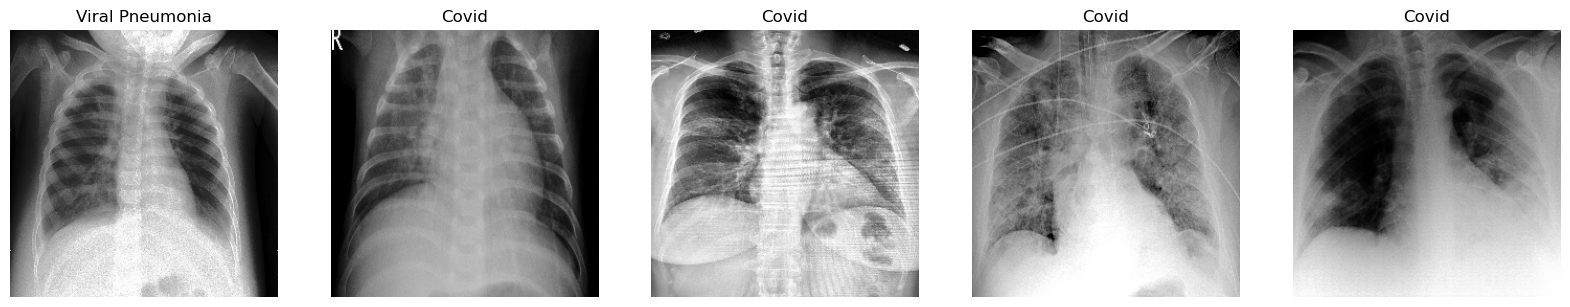

In [26]:
classes = dataset.class_names

plt.figure(figsize=(20, 4))
for image_batch, labels_batch in dataset.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")
plt.show()

In [27]:
print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


In [28]:
for image_batch, labels_batch in dataset.take(len(dataset)): 
        print(image_batch.shape)
        print(labels_batch.numpy())

(64, 256, 256, 3)
[2 2 0 0 0 0 0 0 2 1 0 1 1 1 0 0 2 2 2 0 0 0 1 1 2 2 2 2 1 1 1 1 0 0 0 1 0
 1 1 0 0 1 0 0 1 1 0 2 2 0 1 1 2 2 0 2 0 0 1 1 2 1 0 0]
(64, 256, 256, 3)
[2 0 2 0 1 0 0 0 0 2 1 2 2 1 2 1 2 0 2 1 2 0 0 1 0 0 0 0 1 1 0 0 0 0 1 2 2
 0 2 1 1 0 1 0 0 0 1 0 2 0 2 0 0 0 0 1 2 0 0 0 1 0 0 2]
(64, 256, 256, 3)
[2 0 0 1 0 2 0 1 0 0 0 0 1 0 0 0 0 1 0 2 2 1 1 1 2 0 0 1 0 1 1 0 1 0 0 1 1
 0 0 2 2 0 2 2 0 1 2 2 1 0 2 0 2 0 2 1 0 2 1 1 2 2 2 0]
(59, 256, 256, 3)
[1 0 1 0 1 0 0 0 0 1 2 2 1 1 2 0 0 0 0 2 2 2 2 0 0 1 0 0 2 0 2 1 1 0 2 0 2
 1 0 2 2 0 1 2 1 2 0 2 2 2 0 1 1 1 1 0 0 2 2]


In [29]:
tests = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/covid19-image-dataset/Covid19-dataset/test',
    seed=SEED,
    color_mode='rgb',
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 66 files belonging to 3 classes.


In [30]:
len(tests)

2

In [31]:
len(dataset)

4

In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## **Make Validation Data**

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.3, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [34]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(val_ds)

1

In [36]:
input_shape = (BATCH_SIZE, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (64, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (64, 60, 60, 64)         

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
2/2 [==============================] - 9s 4s/step - loss: 1.0991 - accuracy: 0.3125 - val_loss: 1.0960 - val_accuracy: 0.4062
Epoch 2/50
2/2 [==============================] - 7s 3s/step - loss: 1.0831 - accuracy: 0.4634 - val_loss: 1.0780 - val_accuracy: 0.4531
Epoch 3/50
2/2 [==============================] - 9s 5s/step - loss: 1.0797 - accuracy: 0.4390 - val_loss: 1.0226 - val_accuracy: 0.5625
Epoch 4/50
2/2 [==============================] - 7s 3s/step - loss: 1.0776 - accuracy: 0.4390 - val_loss: 1.0892 - val_accuracy: 0.3594
Epoch 5/50
2/2 [==============================] - 9s 5s/step - loss: 1.0485 - accuracy: 0.4844 - val_loss: 0.9980 - val_accuracy: 0.5254
Epoch 6/50
2/2 [==============================] - 7s 4s/step - loss: 1.0884 - accuracy: 0.4375 - val_loss: 1.0419 - val_accuracy: 0.4375
Epoch 7/50
2/2 [==============================] - 7s 4s/step - loss: 1.0420 - accuracy: 0.5366 - val_loss: 1.0692 - val_accuracy: 0.2188
Epoch 8/50
2/2 [=========================

In [42]:
scores = model.evaluate(tests)

2/2 [==============================] - 1s 9ms/step - loss: 0.3831 - accuracy: 0.8636


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

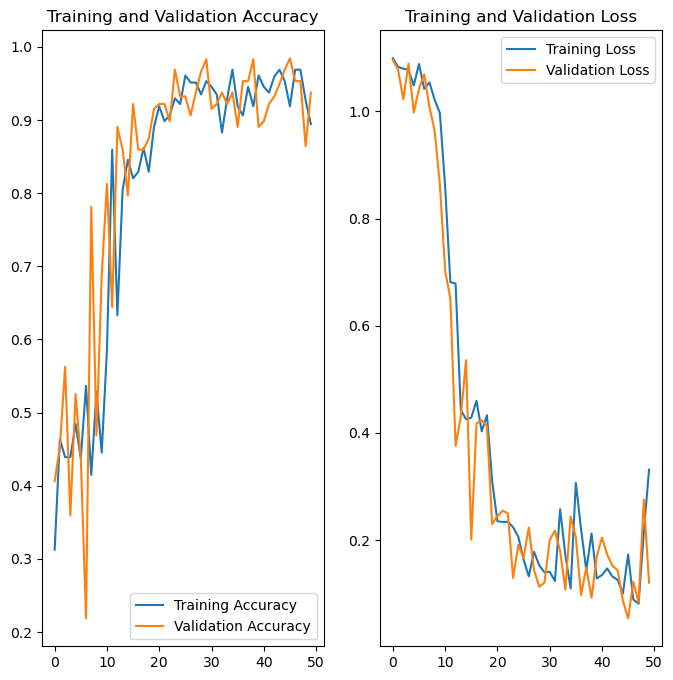

In [46]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


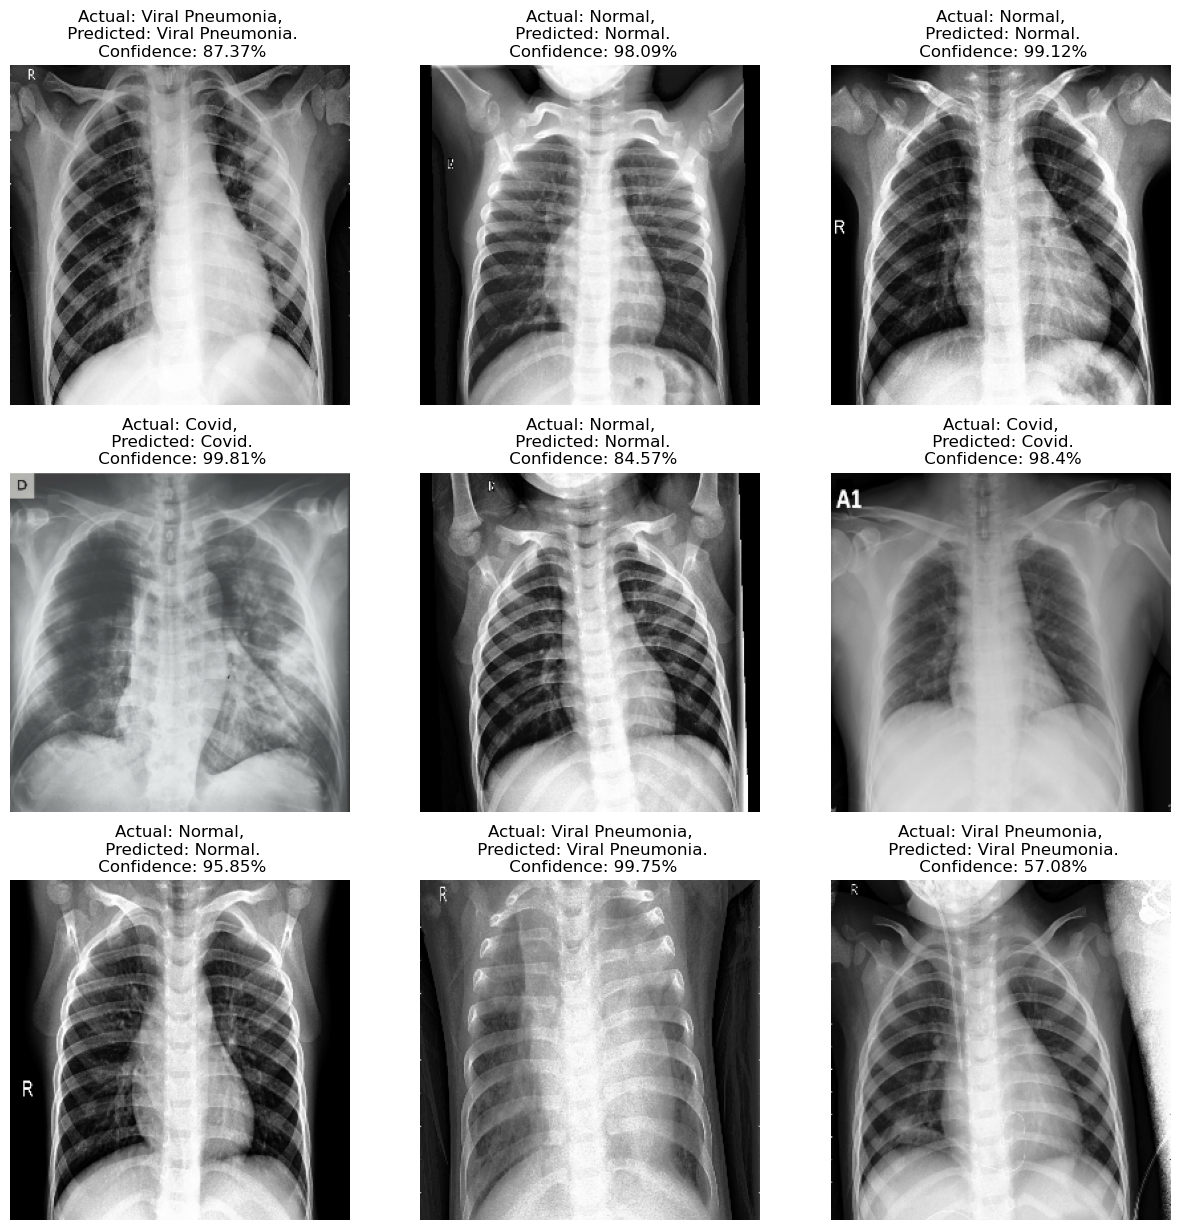

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in tests.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")